# Otus Machine Learning Course. Homework №6 (сбор данных и работа с текстом)
### Воротников Владимир

### Ссылки на основные этапы проделанной работы

[1. Creating own dataset](#1.-Creating-own-dataset)

[1.1 Parsing with scrapy](#1.1-Parsing-with-scrapy)

[1.2 Basic data preparation](#1.2-Basic-Data-Preparation)

[2. NLP](#2.-NLP)

[2.1 Text Preparation](#2.1-Text-preparation)

[2.2 Data modeling with linear regression](#2.2-Data-modeling-with-linear-regression)

[2.3 Tuning parameters](#2.3-Tuning-parameters)

[3. Conclusion](#3.-Conclusion)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = [18, 8]

## 1. Creating own dataset

Выбранная цель для парсинга - текст отзывов на книги (найденные по запросу "Data Science) с сайта Amazon. 

Целевая переменная - количество звёзд, полученных книгой в обзоре (от 1 до 5).

В качестве инструмента для парсинга используется scrapy

### 1.1 Parsing with scrapy
(в данном документе показаны ключевые функции парсера, но не дано полное описание его использования)

Парсер с помощью которого вытаскиваются ссылки на книги (которые потом потребуются для сбора ревью и оценок):

In [ ]:
import scrapy
class AmazonBooksSpider(scrapy.Spider):
 
    # Spider name
    name = 'amazon_books_list'
 
    # Domain names to scrape
    allowed_domains = ['amazon.com']
 
    # Base URL
    myBaseUrl = "https://www.amazon.com/s?k=data+science&i=stripbooks-intl-ship&page="
    start_urls=[]
 
    # Creating list of urls to be scraped by appending page number a the end of base url
    for i in range(1,76):
        start_urls.append(myBaseUrl+str(i))
 
    # Defining a Scrapy parser
    def parse(self, response):
            data = response.css('.s-main-slot')
 
            href = data.css('.s-no-outline')

            for h in href:
                yield {'href' : str(h.attrib['href'])}
 

Парсер с помощью которого вытаскиваются текст отзыва на книги и оценка:

In [ ]:
import scrapy
class AmazonReviewsSpider(scrapy.Spider):
 
    # Spider name
    name = 'amazon_reviews'
 
    # Domain names to scrape
    allowed_domains = ['amazon.com']
    
    start_urls=[]

    with open('book_review_hrefs.csv', 'r') as f:
        file_lines = []
        for x in f.readlines():
            start_urls.append(x)
 
    # Defining a Scrapy parser
    def parse(self, response):
            data = response.css('#cm_cr-review_list')
 
            # Collecting product star ratings
            star_rating = data.css('.review-rating')
 
            # Collecting user reviews
            comments = data.css('.review-text')
            count = 0
 
            # Combining the results
            for review in star_rating:
                yield{'stars:': ''.join(review.xpath('.//text()').extract()),
                      'comment:': ''.join(comments[count].xpath(".//text()").extract()),
                      'url:': response.request.url,
                     }
                count=count+1

### 1.2 Basic Data Preparation

В результате был получен CSV-файл, содержащий текст отзывов на книги, оценку и ссылку на книги. После косметической обработки он выглядит следующим образом:

In [26]:
data = pd.read_csv('data/reviews.csv')

In [27]:
data.head()

,stars,comment,url,id
0,5.0,"Let me say at the outset of this review, that ...",https://www.amazon.com/dp/1492041130,1492041130
1,1.0,Its Capitalism at its best. I read the book fr...,https://www.amazon.com/dp/1492041130,1492041130
2,5.0,If you're looking to get started with data sci...,https://www.amazon.com/dp/1492041130,1492041130
3,4.0,"In general, this is a good book. It covers a w...",https://www.amazon.com/dp/1492041130,1492041130
4,5.0,I was an academic data scientist decades befor...,https://www.amazon.com/dp/1492041130,1492041130


In [28]:
data.shape

(20647, 4)

In [29]:
data.loc[0].comment

'Let me say at the outset of this review, that I respect the author and the sheer guile of trying to attack what is a Ph.D. level topic, in a single book. I have been an SW engineer for the last 15 years, have an engineering degree, and have done some research into GA\'s and image segmentation, many years ago... and I found this book challenging.When I was in college, the joke about Comp Sci was that it was really just "applied math." That wasn\'t really funny, but it is gosh-darned true, doubly so when dealing with data science, AI, and ML, all of which are fancy words for "applied statistics."So, the book gives you a background in various topics such as stat, probability theory, linear algebra, programming, and touches on a few topics from calculus. If you\'re unfamiliar with those things, you will not be able to learn them from one book, or all at once. It\'s just too much.The author leaves lots of bread-crumbs for you to follow. If you\'re not strong any of the subjects I\'ve menti

In [30]:
data.drop(['url', 'id'], axis=1, inplace=True)

In [31]:
data

,stars,comment
0,5.0,"Let me say at the outset of this review, that ..."
1,1.0,Its Capitalism at its best. I read the book fr...
2,5.0,If you're looking to get started with data sci...
3,4.0,"In general, this is a good book. It covers a w..."
4,5.0,I was an academic data scientist decades befor...
...,...,...
20642,3.0,This book offers nice information and thoughts...
20643,5.0,"Am disabled, retired RN, but always wished I w..."
20644,3.0,At one point I considered library work as oppo...
20645,5.0,"Overall, I think this is an excellent resource..."


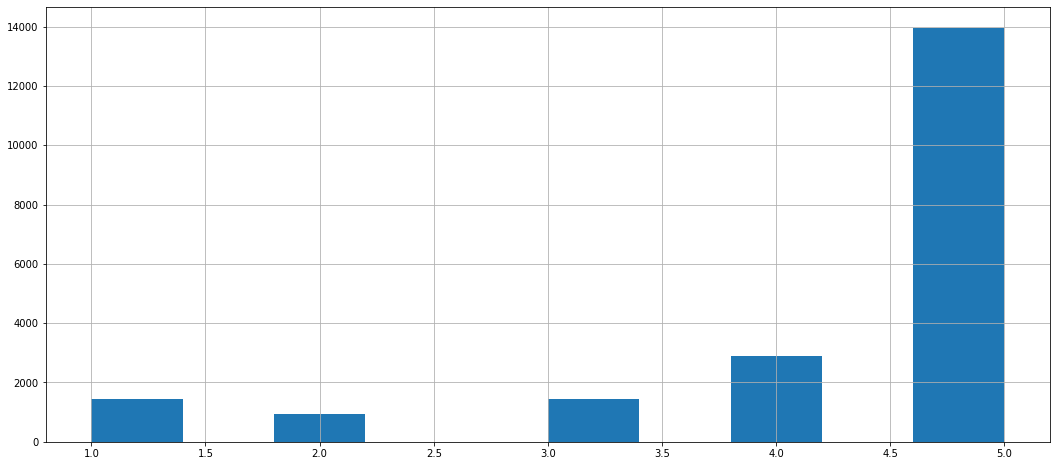

In [32]:
data.stars.hist()

In [33]:
data.stars.value_counts()

5.0    13963
4.0     2894
3.0     1431
1.0     1430
2.0      929
Name: stars, dtype: int64

In [34]:
data.stars.value_counts()/len(data)

5.0    0.676273
4.0    0.140166
3.0    0.069308
1.0    0.069259
2.0    0.044994
Name: stars, dtype: float64

Мы видим, что датасет довольно сильно несбалансирован. Немного компенсируем это удалением самых коротких комментариев с рейтингом 5.

In [35]:
data[data.comment.apply(len)<50].stars.value_counts()

5.0    2084
4.0     316
1.0     120
3.0      95
2.0      61
Name: stars, dtype: int64

In [36]:
data = data.drop(data[data.comment.apply(len)<50][data.stars==5.0].index)

In [37]:
data.stars.value_counts()/len(data)

5.0    0.639929
4.0    0.155902
3.0    0.077089
1.0    0.077035
2.0    0.050046
Name: stars, dtype: float64

## 2. NLP

In [39]:
import nltk
from nltk.tokenize import RegexpTokenizer
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.feature_extraction import DictVectorizer
import string
from collections import Counter
from sklearn.model_selection import train_test_split


### 2.1 Text preparation

In [40]:
X_train, X_test, y_train, y_test = train_test_split(data.comment, data.stars, test_size=0.3, random_state=37)

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', norm=None, min_df=0.005, max_df=0.05)
features_train = vectorizer.fit_transform(X_train).todense()
features_test = vectorizer.transform(X_test).todense()

In [42]:
len(vectorizer.vocabulary_)

1285

In [43]:
features_train.shape

(12994, 1285)

In [44]:
features_test.shape

(5569, 1285)

In [45]:
train_matrix = pd.DataFrame(
    features_train, 
    columns=vectorizer.get_feature_names()
)

test_matrix = pd.DataFrame(
    features_test, 
    columns=vectorizer.get_feature_names()
)

In [46]:
train_matrix

,000,10,100,11,12,15,20,25,2nd,30,...,write,writer,writes,writing,wrong,wrote,year,yes,young,youtube
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12989,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.8772,0.0
12990,0.0,0.0,0.0,0.0,0.0,5.790189,0.0,0.0,6.006412,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0
12991,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.429649,0.0000,0.0
12992,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0


### 2.2 Data modeling with linear regression

In [47]:
from sklearn import metrics  # подгружаем метрики
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats
measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})

In [48]:
y_mean = np.median(y_train)
y_pred_naive = np.ones(len(y_test)) * y_mean
measured_metrics["naive"] = dataframe_metrics(y_test, y_pred_naive)
measured_metrics

,error_type,naive
0,MAE,0.762435
1,RMSE,1.460684
2,R2,-0.374484
3,MAPE,47.245167


In [49]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(cv=5)

lasso_cv.fit(train_matrix, y_train)
print('Лучшее значение параметра:', lasso_cv.alpha_)

y_pred_lasso = lasso_cv.predict(test_matrix)

measured_metrics["lasso_cv"] = dataframe_metrics(y_test, y_pred_lasso)
measured_metrics

Лучшее значение параметра: 0.007774363690497935


,error_type,naive,lasso_cv
0,MAE,0.762435,0.836261
1,RMSE,1.460684,1.095142
2,R2,-0.374484,0.227377
3,MAPE,47.245167,36.440324


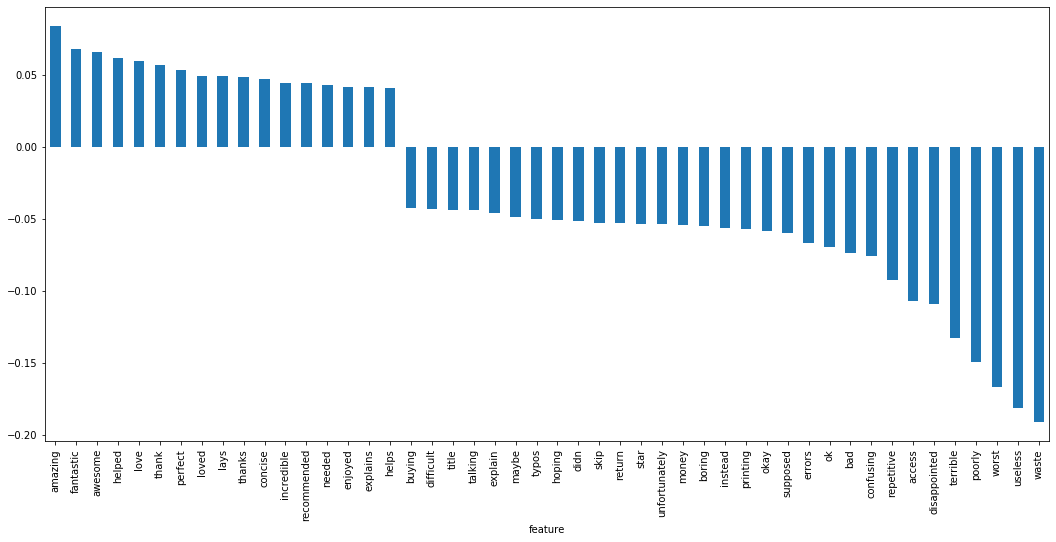

In [51]:
featureImportance = pd.DataFrame({"feature": train_matrix.columns[abs(lasso_cv.coef_)>0.04], 
                                  "importance": lasso_cv.coef_[abs(lasso_cv.coef_)>0.04]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot.bar();

### 2.3 Tuning parameters

Попробуем подобрать более удачные параметры

In [16]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

def objective(params):
    params = {'min_df': float(params['min_df']), 'max_df': float(params['max_df']), 
              'ngram_range': params['ngram_range']}
    
    vectorizer = TfidfVectorizer(stop_words='english', norm=None, max_features=1500, **params)
    
    features_train = vectorizer.fit_transform(X_train).todense()
    features_test = vectorizer.transform(X_test).todense()
    
    train_matrix = pd.DataFrame(
        features_train, 
        columns=vectorizer.get_feature_names()
    )
    test_matrix = pd.DataFrame(
        features_test, 
        columns=vectorizer.get_feature_names()
    )
    
    lasso_cv = LassoCV(cv=5, n_jobs=-1)
    lasso_cv.fit(train_matrix, y_train)
    y_pred_lasso = lasso_cv.predict(test_matrix)
    
    score = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso))
    print("RMSE {:.3f} params {}".format(score, params))
    return score

space = {
    'min_df': hp.quniform('min_df', 0.0001, 0.009, 0.0005),
    'max_df': hp.quniform('max_df', 0.05, 0.2, 0.01),
    'ngram_range': hp.choice('ngram_range', [(1,1), (1,2), (2,2)]),
}


best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

RMSE 1.071 params {'min_df': 0.005, 'max_df': 0.13, 'ngram_range': (1, 2)}                                             
RMSE 1.148 params {'min_df': 0.0015, 'max_df': 0.19, 'ngram_range': (2, 2)}                                            
RMSE 1.073 params {'min_df': 0.0005, 'max_df': 0.18, 'ngram_range': (1, 2)}                                            
RMSE 1.104 params {'min_df': 0.007, 'max_df': 0.05, 'ngram_range': (1, 1)}                                             
RMSE 1.077 params {'min_df': 0.002, 'max_df': 0.16, 'ngram_range': (1, 1)}                                             
RMSE 1.082 params {'min_df': 0.008, 'max_df': 0.18, 'ngram_range': (1, 2)}                                             
RMSE 1.195 params {'min_df': 0.005, 'max_df': 0.1, 'ngram_range': (2, 2)}                                              
RMSE 1.074 params {'min_df': 0.0025, 'max_df': 0.14, 'ngram_range': (1, 1)}                                            
RMSE 1.077 params {'min_df': 0.006, 'max

In [52]:
vectorizer = TfidfVectorizer(stop_words='english',
                             norm=None,
                             max_features=1500,
                             min_df=0,
                             max_df=0.2,
                             ngram_range=(1,2))

features_train = vectorizer.fit_transform(X_train).todense()
features_test = vectorizer.transform(X_test).todense()

train_matrix = pd.DataFrame(
    features_train, 
    columns=vectorizer.get_feature_names()
)
test_matrix = pd.DataFrame(
    features_test, 
    columns=vectorizer.get_feature_names()
)

lasso_cv = LassoCV(cv=10, n_jobs=-1)
lasso_cv.fit(train_matrix, y_train)
y_pred_lasso = lasso_cv.predict(test_matrix)

In [53]:
measured_metrics["lasso_cv_tuned"] = dataframe_metrics(y_test, y_pred_lasso)
measured_metrics

,error_type,naive,lasso_cv,lasso_cv_tuned
0,MAE,0.762435,0.836261,0.812558
1,RMSE,1.460684,1.095142,1.069261
2,R2,-0.374484,0.227377,0.263463
3,MAPE,47.245167,36.440324,35.294427


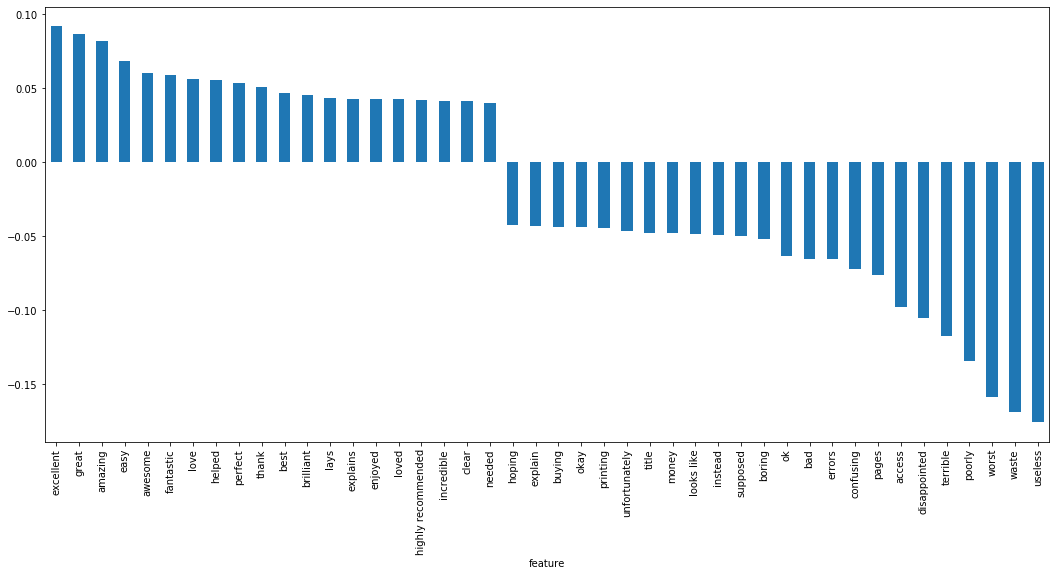

In [54]:
featureImportance = pd.DataFrame({"feature": train_matrix.columns[abs(lasso_cv.coef_)>0.04], 
                                  "importance": lasso_cv.coef_[abs(lasso_cv.coef_)>0.04]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot.bar();

### 3. Conclusion

Ожидаемо, наибольший вклад в высокую оценку вносят слова типа "excellent", "great", ...

Также ожидаемо, что при наличии слов "useless", "waste", "worst"... рейтинг существенно ухудшается

Несколько неожиданно, что в целом позитивные слова "ok", "okay" в топе отрицательных